In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.constants import G

from ReadFile import Read
from CenterOfMass import CenterOfMass

In [2]:
class MassProfile():
# Class to generate an array of enclosed masses and circular velocities
# of a given galaxy and snapshot at a given array of radii
    def __init__(self, galaxy, snap):
        ''' Class to calculate the enclosed mass and circular velocity of a galaxy at 
            a specified snapchot at different radii
            
            PARAMETERS
            ----------
            galaxy : 'str'; 'MW', 'M31', 'M33'
                name of galaxy to be analyzed
            snap : 'int'
                snapshot number
        '''
        self.gname = galaxy # store the name of the galaxy
        
        # add a string of the filenumber to the value “000”
        ilbl = '000' + str(snap)
        # remove all but the last 3 digits
        ilbl = ilbl[-3:]
        self.filename="%s_"%(galaxy) + ilbl + '.txt' # convert to filename
        
        # read data in the given file using Read
        self.time, self.total, self.data = Read(self.filename) 
        
        # store the mass, positions, velocities of only the particles of the given type
        # the following only gives the example of storing the mass
        self.m = self.data['m'] # particle masses
        self.x = self.data['x'] * u.kpc # x positions with units
        self.y = self.data['y'] * u.kpc # y positions with units
        self.z = self.data['z'] * u.kpc # z positions with units
        
    def MassEnclosed(self, ptype, r):
        ''' Function to compute the enclosed mass of a given particle type
            at specified radii from the center of mass position of a galaxy.
            
        PARAMETERS
        ----------
        ptype : 'int'
            particle type to use for enclosed mass calculation
            1-Dark Matter, 2-Disk, or 3-Bulge
        r : 'array'
            array of radius magnitude values to compute enclosed mass at
        
        RETURNS
        -------
        mass : 'array'
            array of enclosed masses, each element is the enclosed mass
            at each specified radius (Msun)
        '''
        galaxy_COM = CenterOfMass(self.filename, ptype) # COM object for calculation
        galaxy_COM_p = galaxy_COM.COM_P(0.1) # determine COM using iterative method
        mass = np.empty(len(r)) # empty array to store enclosed masses
        
        # get all the indices of the particles from data array of specified type
        ptype_indices = np.where(self.data['type'] == ptype)
        x_ptype = self.x[ptype_indices] - galaxy_COM_p[0] # x position relative to COM
        y_ptype = self.y[ptype_indices] - galaxy_COM_p[1] # y position relative to COM
        z_ptype = self.z[ptype_indices] - galaxy_COM_p[2] # z position relative to COM
        
        # create a new array stacking position components together and get magnitudes
        particle_radius_vectors = np.vstack((x_ptype, y_ptype, z_ptype))
        # get magnitude of particle radii and remove units for comparison
        particle_radii = np.linalg.norm(particle_radius_vectors, axis=0).value
        for i in range(len(r)): # calculate enclosed mass at each radius
            # indices of all the particles within each radius value in array
            enclosed_particle_indices = np.where(particle_radii < r[i])
            masses_ptype = self.m[ptype_indices] # masses of all same type particles
            # enclosed mass is the sum of all particles within radius of given type
            mass[i] = np.sum(masses_ptype[enclosed_particle_indices])
        
        return mass * 1e10 * u.Msun # return enclosed masses with units
        
    def MassEnclosedTotal(self, r):
        ''' Function to compute the enclosed mass at given radii of 
            all galaxy components
        
        PARAMETERS
        ----------
        r : 'array'
            array of radius magnitude values to compute enclosed mass at
        
        RETURNS
        -------
        mass : 'array'
            array of enclosed masses, each element is the enclosed mass
            at each specified radius (Msun)
        '''
        darkmatter_enclosed_mass = self.MassEnclosed(1, r) # dark matter component
        disk_enclosed_mass = self.MassEnclosed(2, r) # disk mass component
        
        if self.gname != "M33": # M33 has no bulge so only others need to add it
            bulge_enclosed_mass = self.MassEnclosed(2, r) # bulge mass component
            return darkmatter_enclosed_mass + disk_enclosed_mass \
                   + bulge_enclosed_mass # return enclosed mass of all types
        return darkmatter_enclosed_mass + disk_enclosed_mass # M33 total enclosed mass
    
    def HernquistMass(self, r, a=60, Mhalo=1.975):
        ''' Function that defines the Hernquist 1990 mass profile
            adapted from in-class lab 3
        PARAMETERS
        ----------
        r : 'array'
            radius magnitude values to compute enclosed mass at
        a: 'astropy quantity'
            scale radius of Hernquist profile in kpc
        m_halo: 'float'
            total halo mass in units 1e12 Msun
                
        RETURNS
        -------
        mass: 'astropy quantity'
            total mass within the given r in Msun 
        '''
        mass = Mhalo * 1e12 * r**2 / (a + r)**2*u.Msun # Hernquist Mass
        return mass
    
    def CircularVelocity(self, ptype, r):
        ''' Function to determine circular speeds of particles at given 
            radii caused by the enclosed mass of a specified component
        
        PARAMETERS
        ----------
        ptype : 'int'
            particle type to use for enclosed mass calculation
            1-Dark Matter, 2-Disk, or 3-Bulge
        r : 'array'
            array of radius magnitude values to compute enclosed mass at
        
        RETURNS
        -------
        circular_speeds : 'array'
            array of circular speeds, each element is the circular speed
            from component enclosed mass at each specified radius (km/s)
        '''
        masses = self.MassEnclosed(ptype, r) # enclosed masses at each radius
        G_units = G.to(u.kpc*u.km**2/u.s**2/u.Msun) # G constant in desired units
        # formula for velocity in circular orbit given enclosed mass and radius
        return np.sqrt(G_units*masses/(r*u.kpc)) * u.km/u.s # return with units
    
    def CircularVelocityTotal(self, r):
        ''' Function to determine circular speeds of particles at given 
            radii caused by the enclosed mass of all components
        
        PARAMETERS
        ----------
        r : 'array'
            array of radius magnitude values to compute enclosed mass at
        
        RETURNS
        -------
        circular_speeds : 'array'
            array of circular speeds, each element is the circular speed
            from total enclosed mass at each specified radius (km/s)
        '''
        masses = self.MassEnclosedTotal(r) # enclosed masses at each radius
        G_units = G.to(u.kpc*u.km**2/u.s**2/u.Msun) # G constant in desired units
        return np.sqrt(G_units*masses/(r*u.kpc)) * u.km/u.s # return with units
    
    def HernquistVCirc(self, r, a, Mhalo):
        ''' Function to determine circular speeds of particles at given 
            radii caused by the enclosed mass from a Hernquist profile
        
        PARAMETERS
        ----------
        r : 'array'
            radius magnitude values to compute enclosed mass at
        a: 'astropy quantity'
            scale radius of Hernquist profile in kpc
        m_halo: 'float'
            total halo mass in units 1e12 Msun
        
        RETURNS
        -------
        circular_speeds : 'array'
            array of circular speeds, each element is the circular speed
            from Hernquist profile enclosed mass at each specified radius (km/s)
        '''
        masses = self.HernquistMass(r, a, Mhalo) # Hernquist mass at each radius
        G_units = G.to(u.kpc*u.km**2/u.s**2/u.Msun) # G constant in desired units
        return np.sqrt(G_units*masses/(r*u.kpc)) * u.km/u.s # return with units


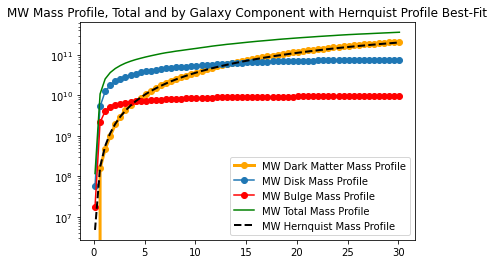

In [3]:
MW = MassProfile("MW", 0) # MassProfile object for MW
r = np.arange(0.1, 30.5, 0.5) # Array of radii to test, up to 30 kpc
MW_darkmatter_mass_enclosed = MW.MassEnclosed(1, r) # enclosed dark matter mass at each radius
MW_disk_mass_enclosed = MW.MassEnclosed(2, r) # enclosed disk mass at each radius
MW_bulge_mass_enclosed = MW.MassEnclosed(3, r) # enclosed bulge mass at each radius
MW_total_mass_enclosed = MW.MassEnclosedTotal(r) # enclosed mass from all components at each radius
MW_darkmatter_mass_total = MW.MassEnclosed(1, [np.inf]) # total dark matter mass of galaxy (out to infinity)
# Hernquist profile generated using total dark matter mass from above
MW_Hernquist_mass_enclosed = MW.HernquistMass(r, a=64, Mhalo=MW_darkmatter_mass_total/u.Msun/1e12)

# plot the mass profiles from each component, the total, and the estimated best fit Hernquist
plt.semilogy(r, MW_darkmatter_mass_enclosed, 'o-', c='orange', lw=3, \
             label='MW Dark Matter Mass Profile')
plt.semilogy(r, MW_disk_mass_enclosed, 'o-', label='MW Disk Mass Profile')
plt.semilogy(r, MW_bulge_mass_enclosed, 'o-', c='red', label='MW Bulge Mass Profile')
plt.semilogy(r, MW_total_mass_enclosed, color='green', label='MW Total Mass Profile')
plt.semilogy(r, MW_Hernquist_mass_enclosed, ls='--', lw=2, color='black', \
             label='MW Hernquist Mass Profile')

plt.legend()
plt.title('MW Mass Profile, Total and by Galaxy Component with Hernquist Profile Best-Fit')

'Best fit Hernquist profile scale length for MW: a=64 kpc';

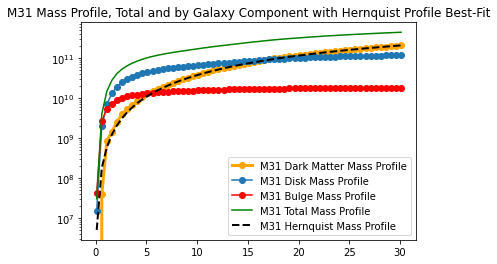

In [4]:
M31 = MassProfile("M31", 0) # MassProfile object for M31
r = np.arange(0.1, 30.5, 0.5) # Array of radii to test, up to 30 kpc
M31_darkmatter_mass_enclosed = M31.MassEnclosed(1, r) # enclosed dark matter mass at each radius
M31_disk_mass_enclosed = M31.MassEnclosed(2, r) # enclosed disk mass at each radius
M31_bulge_mass_enclosed = M31.MassEnclosed(3, r) # enclosed bulge mass at each radius
M31_total_mass_enclosed = M31.MassEnclosedTotal(r) # enclosed mass from all components at each radius
M31_darkmatter_mass_total = M31.MassEnclosed(1, [np.inf]) # total dark matter mass of galaxy (out to infinity)
# Hernquist profile generated using total dark matter mass from above
M31_Hernquist_mass_enclosed = M31.HernquistMass(r, a=62, Mhalo=M31_darkmatter_mass_total/u.Msun/1e12)

# plot the mass profiles from each component, the total, and the estimated best fit Hernquist
plt.semilogy(r, M31_darkmatter_mass_enclosed, 'o-', c='orange', lw=3, \
             label='M31 Dark Matter Mass Profile')
plt.semilogy(r, M31_disk_mass_enclosed, 'o-', label='M31 Disk Mass Profile')
plt.semilogy(r, M31_bulge_mass_enclosed, 'o-', c='red', label='M31 Bulge Mass Profile')
plt.semilogy(r, M31_total_mass_enclosed, color='green', label='M31 Total Mass Profile')
plt.semilogy(r, M31_Hernquist_mass_enclosed, ls='--', lw=2, color='black', \
             label='M31 Hernquist Mass Profile')

plt.legend()
plt.title('M31 Mass Profile, Total and by Galaxy Component with Hernquist Profile Best-Fit')

'Best fit Hernquist profile scale length for M31: a=62 kpc';

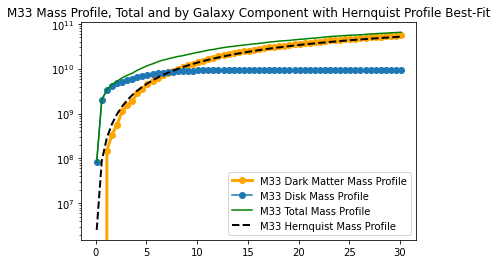

In [5]:
M33 = MassProfile("M33", 0) # MassProfile object for M33 (no bulge, so bulge component left out)
r = np.arange(0.1, 30.5, 0.5) # Array of radii to test, up to 30 kpc
M33_darkmatter_mass_enclosed = M33.MassEnclosed(1, r) # enclosed dark matter mass at each radius
M33_disk_mass_enclosed = M33.MassEnclosed(2, r) # enclosed disk mass at each radius
M33_total_mass_enclosed = M33.MassEnclosedTotal(r) # enclosed mass from all components at each radius
M33_darkmatter_mass_total = M33.MassEnclosed(1, [np.inf]) # total dark matter mass of galaxy (out to infinity)
# Hernquist profile generated using total dark matter mass from above
M33_Hernquist_mass_enclosed = M33.HernquistMass(r, a=27, Mhalo=M33_darkmatter_mass_total/u.Msun/1e12)

# plot the mass profiles from each component, the total, and the estimated best fit Hernquist
plt.semilogy(r, M33_darkmatter_mass_enclosed, 'o-', c='orange', lw=3, label='M33 Dark Matter Mass Profile')
plt.semilogy(r, M33_disk_mass_enclosed, 'o-', label='M33 Disk Mass Profile')
plt.semilogy(r, M33_total_mass_enclosed, color='green', label='M33 Total Mass Profile')
plt.semilogy(r, M33_Hernquist_mass_enclosed, ls='--', lw=2, color='black', label='M33 Hernquist Mass Profile')

plt.legend()
plt.title('M33 Mass Profile, Total and by Galaxy Component with Hernquist Profile Best-Fit')

'Best fit Hernquist profile scale length for M33: a=27 kpc';

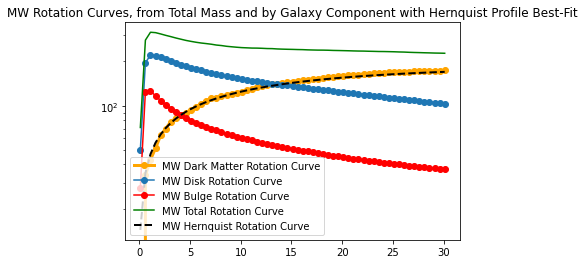

In [6]:
# reuse MassProfile objects from previous plots
r = np.arange(0.1, 30.5, 0.5) # using same radii
MW_darkmatter_circular_velocity = MW.CircularVelocity(1, r) # circular speed from dark matter component
MW_disk_circular_velocity = MW.CircularVelocity(2, r) # circular speed from disk component
MW_bulge_circular_velocity = MW.CircularVelocity(3, r) # circular speed from bulge component
MW_total_circular_velocity = MW.CircularVelocityTotal(r) # circular speed from all mass components
# total circular speed from Hernquist profile using previous scale length and halo mass
MW_Hernquist_circular_velocity = MW.HernquistVCirc(r, a=64, Mhalo=MW_darkmatter_mass_total/u.Msun/1e12)

# plot the rotation curves from each component, the total, and the estimated best fit Hernquist
plt.semilogy(r, MW_darkmatter_circular_velocity, 'o-', c='orange', lw=3, \
             label='MW Dark Matter Rotation Curve')
plt.semilogy(r, MW_disk_circular_velocity, 'o-', label='MW Disk Rotation Curve')
plt.semilogy(r, MW_bulge_circular_velocity, 'o-', c='red', label='MW Bulge Rotation Curve')
plt.semilogy(r, MW_total_circular_velocity, color='green', label='MW Total Rotation Curve')
plt.semilogy(r, MW_Hernquist_circular_velocity, ls='--', lw=2, color='black', \
             label='MW Hernquist Rotation Curve')

plt.legend()
plt.title('MW Rotation Curves, from Total Mass and by Galaxy Component with Hernquist Profile Best-Fit')

'Best fit Hernquist profile scale length: a=64 kpc';

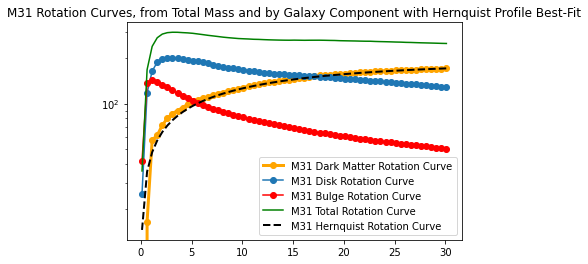

In [7]:
# reuse MassProfile objects from previous plots
r = np.arange(0.1, 30.5, 0.5) # using same radii
M31_darkmatter_circular_velocity = M31.CircularVelocity(1, r) # circular speed from dark matter component
M31_disk_circular_velocity = M31.CircularVelocity(2, r) # circular speed from disk component
M31_bulge_circular_velocity = M31.CircularVelocity(3, r) # circular speed from bulge component
M31_total_circular_velocity = M31.CircularVelocityTotal(r) # circular speed from all mass components
# total circular speed from Hernquist profile using previous scale length and halo mass
M31_Hernquist_circular_velocity = M31.HernquistVCirc(r, a=62, Mhalo=M31_darkmatter_mass_total/u.Msun/1e12)

# plot the rotation curves from each component, the total, and the estimated best fit Hernquist
plt.semilogy(r, M31_darkmatter_circular_velocity, 'o-', c='orange', lw=3, \
             label='M31 Dark Matter Rotation Curve')
plt.semilogy(r, M31_disk_circular_velocity, 'o-', label='M31 Disk Rotation Curve')
plt.semilogy(r, M31_bulge_circular_velocity, 'o-', c='red', label='M31 Bulge Rotation Curve')
plt.semilogy(r, M31_total_circular_velocity, color='green', label='M31 Total Rotation Curve')
plt.semilogy(r, M31_Hernquist_circular_velocity, ls='--', lw=2, color='black', \
             label='M31 Hernquist Rotation Curve')

plt.legend()
plt.title('M31 Rotation Curves, from Total Mass and by Galaxy Component with Hernquist Profile Best-Fit')

'Best fit Hernquist profile scale length: a=64 kpc';

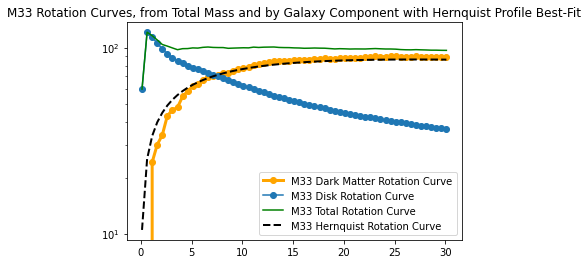

In [8]:
# reuse MassProfile objects from previous plots (again, M33 has no bulge)
r = np.arange(0.1, 30.5, 0.5) # using same radii
M33_darkmatter_circular_velocity = M33.CircularVelocity(1, r) # circular speed from dark matter component
M33_disk_circular_velocity = M33.CircularVelocity(2, r) # circular speed from disk component
M33_total_circular_velocity = M33.CircularVelocityTotal(r) # circular speed from all mass components
# total circular speed from Hernquist profile using previous scale length and halo mass
M33_Hernquist_circular_velocity = M33.HernquistVCirc(r, a=27, Mhalo=M33_darkmatter_mass_total/u.Msun/1e12)

# plot the rotation curves from each component, the total, and the estimated best fit Hernquist
plt.semilogy(r, M33_darkmatter_circular_velocity, 'o-', c='orange', lw=3, \
             label='M33 Dark Matter Rotation Curve')
plt.semilogy(r, M33_disk_circular_velocity, 'o-', label='M33 Disk Rotation Curve')
plt.semilogy(r, M33_total_circular_velocity, color='green', label='M33 Total Rotation Curve')
plt.semilogy(r, M33_Hernquist_circular_velocity, ls='--', lw=2, color='black', \
             label='M33 Hernquist Rotation Curve')

plt.legend()
plt.title('M33 Rotation Curves, from Total Mass and by Galaxy Component with Hernquist Profile Best-Fit')

'Best fit Hernquist profile scale length: a=27 kpc';